In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('../names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182510, 3]) torch.Size([182510])
torch.Size([22768, 3]) torch.Size([22768])
torch.Size([22868, 3]) torch.Size([22868])


In [6]:
n_embd = 10
n_hidden = 200

C  = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3060
  10000/ 200000: 2.2163
  20000/ 200000: 2.0885
  30000/ 200000: 2.5868
  40000/ 200000: 2.2812
  50000/ 200000: 2.3932
  60000/ 200000: 2.0781
  70000/ 200000: 2.1986
  80000/ 200000: 1.8017
  90000/ 200000: 2.2784
 100000/ 200000: 2.2719
 110000/ 200000: 2.0395
 120000/ 200000: 1.9736
 130000/ 200000: 2.2732
 140000/ 200000: 1.8502
 150000/ 200000: 2.3008
 160000/ 200000: 2.2630
 170000/ 200000: 1.7322
 180000/ 200000: 1.9088
 190000/ 200000: 2.0429


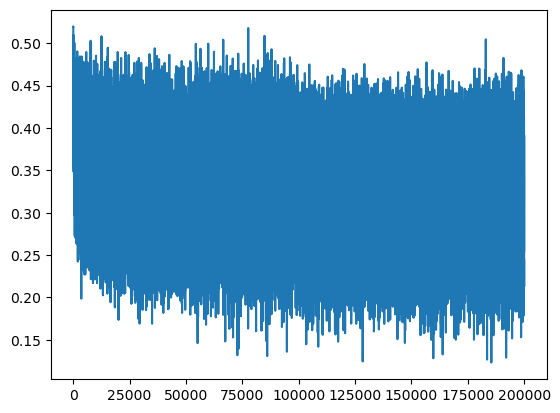

In [8]:
plt.plot(lossi)

In [9]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [10]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.064049482345581
val 2.11594820022583


In [13]:
class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn(fan_in,fan_out)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out  = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma,self.beta]

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10
n_hidden = 100

C = torch.randn(vocab_size,n_embd)

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47024


In [15]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 2.4712
  10000/ 200000: 2.2862
  20000/ 200000: 2.1965
  30000/ 200000: 2.0157
  40000/ 200000: 2.2913
  50000/ 200000: 2.5385
  60000/ 200000: 2.0260
  70000/ 200000: 1.6607
  80000/ 200000: 1.8789
  90000/ 200000: 2.0936
 100000/ 200000: 1.9517
 110000/ 200000: 2.1078
 120000/ 200000: 2.1734
 130000/ 200000: 2.0419
 140000/ 200000: 2.1149
 150000/ 200000: 2.1500
 160000/ 200000: 2.1426
 170000/ 200000: 1.9387
 180000/ 200000: 2.2010
 190000/ 200000: 1.9397


layer 2 (      Tanh): mean +0.01, std 0.69, saturated: 17.41%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 20.59%
layer 8 (      Tanh): mean -0.01, std 0.77, saturated: 20.59%
layer 11 (      Tanh): mean -0.01, std 0.79, saturated: 22.34%
layer 14 (      Tanh): mean -0.01, std 0.81, saturated: 25.28%


Text(0.5, 1.0, 'activation distribution')

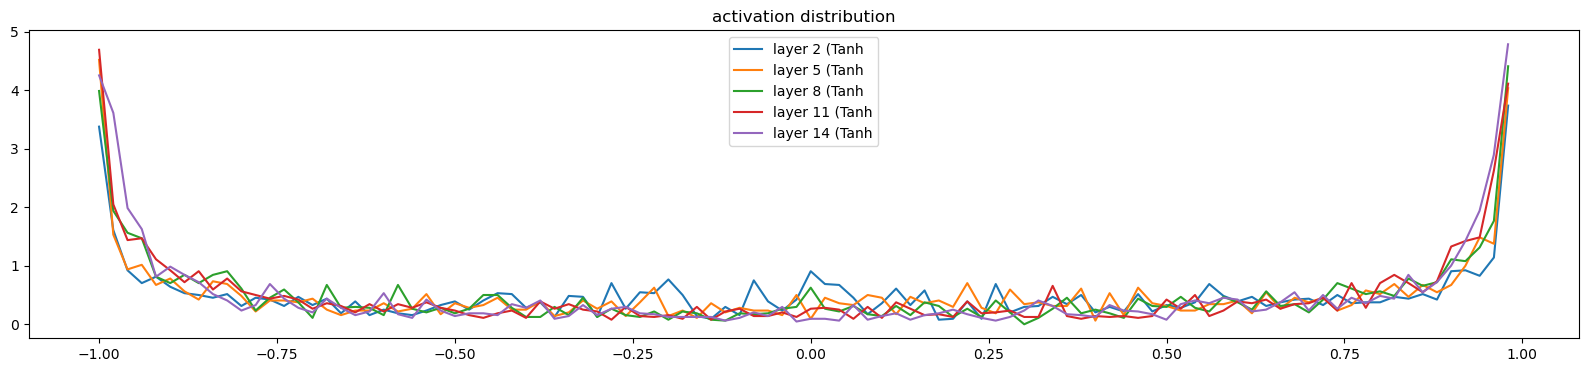

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 5.665097e-03
layer 5 (      Tanh): mean +0.000000, std 4.540288e-03
layer 8 (      Tanh): mean -0.000000, std 3.742580e-03
layer 11 (      Tanh): mean +0.000000, std 3.563711e-03
layer 14 (      Tanh): mean +0.000000, std 3.871589e-03


Text(0.5, 1.0, 'gradient distribution')

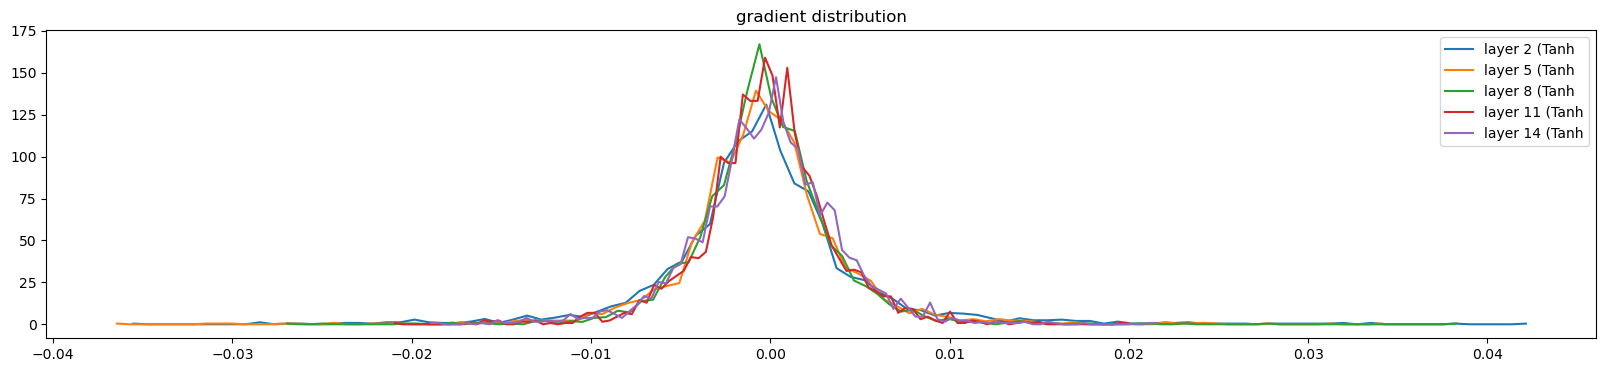

In [17]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 2.529561e-02 | grad:data ratio 2.187481e-02
weight  (30, 100) | mean -0.000092 | std 1.144700e-02 | grad:data ratio 2.859028e-02
weight (100, 100) | mean -0.000075 | std 6.698854e-03 | grad:data ratio 2.765266e-02
weight (100, 100) | mean -0.000008 | std 6.250884e-03 | grad:data ratio 2.596896e-02
weight (100, 100) | mean +0.000040 | std 6.154774e-03 | grad:data ratio 2.674386e-02
weight (100, 100) | mean +0.000039 | std 5.616381e-03 | grad:data ratio 2.598057e-02
weight  (100, 27) | mean -0.000044 | std 1.135277e-02 | grad:data ratio 3.199891e-02


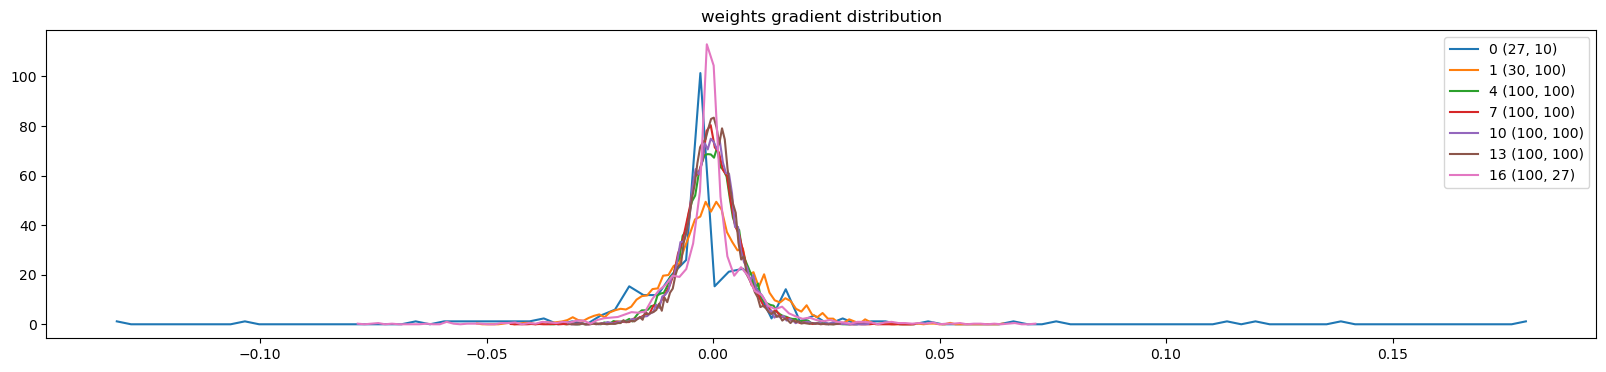

In [18]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [19]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.002638339996338
val 2.087451934814453


In [20]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

shlani.
shawn.
emoranya.
wylian.
mckennah.
lin.
nee.
fary.
mumeel.
deven.
lan.
min.
ari.
axtyn.
nayidenna.
justa.
lavayden.
gerenne.
jozy.
bryne.
